<a href="https://colab.research.google.com/github/kterashi/niigata_lecture_2024/blob/master/Lec23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulator, Quantum States, Function, Inner Products, Quantum Teleportation

**Basics of quantum computation and quantum algorithms**

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

In [1]:
# First, get all the necessary libraries from the copy and import packages
import os
import sys
import shutil
import tarfile
from google.colab import drive
drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.10/site-packages')

ModuleNotFoundError: No module named 'google'

In [2]:
# Import everything
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.accounts import AccountNotFoundError

runtime_config_path = '/content/gdrive/MyDrive/qiskit-ibm.json'
from qc_workbook.show_state import statevector_expr
from qc_workbook.utils import operational_backend

print('notebook ready')

notebook ready


## Preparation: State-vector simulator and mathematical expression of state vector

In order to examine a quantum state more closely, one can use the state-vector simulator in Qiskit's `AerSimulator`. The state-vector simulator allows us to access full information about quantum states including amplitudes of all computational basis states at the output of the circuit.

In [3]:
simulator = AerSimulator(method='statevector')
print(simulator.name)

aer_simulator_statevector


Example:

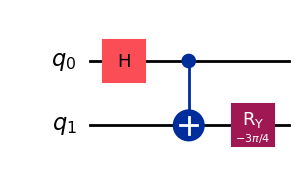

In [4]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)

# Not measure_all() to access quantum states at the end of the circuit

circuit.draw('mpl')

For now, just ignore what the 'transpile()' function does. We use `result.data()['statevector']` to get the state vector instead of `result.get_counts()` which will be used later to get measured counts.

In [5]:
def get_statevector_array(circuit):
    # Use a copy of the circuit in argument
    circuit = circuit.copy()
    # Instruction to store the state vector in the final state of the circuit
    circuit.save_statevector()
    # "Transpile" the circuit and run
    circuit = transpile(circuit, backend=simulator)
    job = simulator.run(circuit)
    result = job.result()
    qiskit_statevector = result.data()['statevector']

    # result.data()['statevector'] is not a numpy array but an instance of a Qiskit class.
    # It can be converted to a numpy array (ndarray) using np.asarray()
    return np.asarray(qiskit_statevector)

statevector = get_statevector_array(circuit)
print(type(statevector), statevector.dtype)
print(statevector)

<class 'numpy.ndarray'> complex128
[ 0.27059805+0.j  0.65328148+0.j -0.65328148+0.j  0.27059805+0.j]


Below we use `statevector_expr` function defined in qc_workbook module to express the array of state vectors in mathematical form.

In [6]:
expr = statevector_expr(statevector)

# Typesetting in LaTeX using Math()
Math(expr)

<IPython.core.display.Math object>

## Creation of simple quantum states

### Exercise 1: Single-qubit state with relative phase

**Exercise**

Create the folowing single-qubit state:

$$
\frac{1}{\sqrt{2}}\left(\ket{0} + i\ket{1}\right)
$$


In [7]:
circuit = QuantumCircuit(1)

circuit.h(0)
circuit.p(np.pi / 2., 0)
# ?????

In [8]:
# The statevector_expr function can be augmented with a QuantumCircuit object.
# amp_norm is an option to specify the normalization of amplitudes.
expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

### Exercise 2: Bell state with relative phase

**Exercise**

Create the following 2-qubit state:

$$
\frac{1}{\sqrt{2}}\left(\ket{0} + i\ket{3}\right) = \frac{1}{\sqrt{2}}\left(\ket{00} + i\ket{11}\right)
$$


In [9]:
circuit = QuantumCircuit(2)

circuit.h(0)
circuit.p(np.pi / 2., 0)
circuit.cx(0, 1)
# ?????

In [10]:
expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

### Exercise 3: GHZ state

**Exercise**

Create the following 3-qubit state:

$$
\frac{1}{\sqrt{2}} (\ket{0} + \ket{7}) = \frac{1}{\sqrt{2}} (\ket{000} + \ket{111})
$$


In [11]:
circuit = QuantumCircuit(3)

circuit.h(0)
circuit.cx(0, 1)
circuit.mcx([0, 1], 2)
# ?????

In [12]:
expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

### Exercise 4: Equal superposition state

**Exercise**

Construct a quantum circuit to create the following $n$-qubit state:

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

and implement the circuit for $n=4$.


In [14]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

for i in range(num_qubits):
    circuit.h(i)
# ?????

In [15]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
expr = statevector_expr(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n))
Math(expr)

<IPython.core.display.Math object>

### Exercise 5: Flip the sign of a certain basis state

**Exercise**

Construct a quantum circuit to flip the sign of a given basis state $\ket{5} = \ket{0101}$ for the 4-qubit equal superposition state created above in Exercise 4.


In [18]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

for i in range(num_qubits):
    circuit.h(i)

circuit.x(1)
circuit.x(3)
circuit.mcp(np.pi, [0, 1, 2], 3)
circuit.x(1)
circuit.x(3)
# ?????

In [19]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
expr = statevector_expr(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n))
Math(expr)

<IPython.core.display.Math object>

### Exercise 6: Apply a phase shift to equal superposition state

**Exercise**

Consider a quantum circuit to create the following $n$-qubit state:

$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i s k/2^n} \ket{k} \quad (s \in \mathbb{R})
$$

and implment the circuit for $n=6$ and $s=2.5$.

Actually this circuit will be better understood after we learn the Quantum Fourier Transform. Let's come back later.

In [20]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

s = 2.5

for m in range(num_qubits):
    circuit.h(m)
    circuit.p(2. * np.pi * s / (2 ** (num_qubits - m)), m)
# ?????

In [21]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

## Function

Quantum circuit of the function $f$ that takes the value $x \in \{0, \dots, 7\}$ as an argument, then returns $15 - x$:

$$
U_{f}\ket{y}\ket{x} = \ket{y \oplus f(x)}\ket{x}
$$

In [ ]:
input_register = QuantumRegister(3, name='input')
output_register = QuantumRegister(4, name='output')

circuit = QuantumCircuit(input_register, output_register)

# Assign some number (e.g, 6) to input_register
circuit.x(input_register[1])
circuit.x(input_register[2])

circuit.barrier()

# U_f that performs subtraction
# First, all the bits in output_register are set 1
circuit.x(output_register)
for idx in range(3):
    # When a bit in input_register is 1, the corresponding bit in output_register is flipped with CNOT gate
    circuit.cx(input_register[idx], output_register[idx])

circuit.draw('mpl')

In [ ]:
Math(statevector_expr(circuit, register_sizes=[3, 4]))

## Inner product of state vectors

Now let's take a look at the square of inner product $|\braket{\psi}{\phi}|^2$ between two quantum states $\ket{\psi}$ and $\ket{\phi}$.

First, for the following states:
$$
\begin{split}
\ket{\psi} = \sum_{k=0}^{2^n-1} c_k \ket{k} \\
\ket{\phi} = \sum_{k=0}^{2^n-1} d_k \ket{k}
\end{split}
$$

the inner prouduct is defined to be

$$
\braket{\psi}{\phi} = \sum_{k=0}^{2^n-1} c^{*}_k d_k
$$

The inner product has the following important property, called Cauchy-Schwarz inequality.

$$
\begin{split}
0 \leq |\braket{\psi}{\phi}|^2 \leq 1 \\
|\braket{\psi}{\phi}|^2 = 1 \; \text{iff} \; \ket{\psi} \sim \ket{\phi}
\end{split}
$$


### Exercise: Inner product by SWAP test

Let us calculate the inner product by using SWAP test.

The $\ket{\psi}$ and $\ket{\phi}$ are both 3-qubit states, and we try to obtain the inner product from the probabilities $P_0$ and $P_1$ of measuring 0 and 1, respectively, in a `test` register:

$$
P_0 - P_1 = |\braket{\psi}{\phi}|^2
$$

In [ ]:
data_width = 3

fig, axs = plt.subplots(1, 2)

# Circuit to create a certain state |ψ>
psi_circuit = QuantumCircuit(data_width, name='|ψ>')
psi_circuit.ry(0.7, 2)
psi_circuit.cx(2, 1)
psi_circuit.rz(0.5, 1)
psi_circuit.cx(1, 0)
psi_circuit.draw('mpl', ax=axs[0])
axs[0].set_title(r'$\psi$')

# Circuit to create a certain state |φ>
phi_circuit = QuantumCircuit(data_width, name='|φ>')
phi_circuit.rx(1.2, 0)
phi_circuit.ry(2.1, 1)
phi_circuit.cx(0, 2)
phi_circuit.cz(1, 2)
phi_circuit.ry(0.8, 2)
phi_circuit.draw('mpl', ax=axs[1])
axs[1].set_title(r'$\phi$')

# Create a circuit to calculate inner product with SWAP test
reg_data1 = QuantumRegister(data_width, name='data1')
reg_data2 = QuantumRegister(data_width, name='data2')
reg_test = QuantumRegister(1, name='test')
out = ClassicalRegister(1, name='out')

circuit = QuantumCircuit(reg_data1, reg_data2, reg_test, out, name='SWAP_test')

# Have states |ψ> and |φ> in data registers
# You can use append() method to implement other circuits or gates into a circuit object
# qargs specifies to which qubits of the target circuit a specified circuit is implemented.
circuit.append(psi_circuit, qargs=reg_data1)
circuit.append(phi_circuit, qargs=reg_data2)

# Add barrier for visibility (no computation by barrier)
circuit.barrier()

# SWAP test
circuit.h(reg_test)

for idx in range(data_width):
    circuit.cswap(reg_test[0], reg_data1[idx], reg_data2[idx])

circuit.h(reg_test)

circuit.measure(reg_test, out)

circuit.draw('mpl')

Let us check the states from the circuits.

In [ ]:
# |ψ>
Math(statevector_expr(psi_circuit, state_label=r'\psi'))

In [ ]:
# |φ>
Math(statevector_expr(phi_circuit, state_label=r'\phi'))

The inner product square $|\braket{\psi}{\phi}|^2$ is

In [ ]:
sv_psi = get_statevector_array(psi_circuit)
sv_phi = get_statevector_array(phi_circuit)
print(np.square(np.abs(np.sum(sv_psi.conjugate() * sv_phi))))

The $P_0 - P_1$ obtained from measuring the circuit 1000000 times is

In [ ]:
simulator = AerSimulator()
shots = 1000000

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

print((counts.get('0', 0) - counts.get('1', 0)) / shots)

### Inner product by inverse circuit

If we know how to generate the states $\ket{\psi}$ and $\ket{\phi}$, the inner product can be calculated directly. Suppose the $\ket{\psi}$ ($\ket{\phi}$) is generated by applying the unitary operator $U_\psi$ ($U_\phi$) to the initial $\ket{0}$ state, the inner product can be calculated by applying the $U_\phi$ and the inverse unitary $U_\psi^\dagger$ and evaluating the probability $P_0$ of measuring 0 in all qubits, that is

$$
P_0 = |\langle 0|U_\psi^\dagger U_\phi\ket{0}|^2 = |\braket{\psi}{\phi}|^2
$$

In [ ]:
reg_data = QuantumRegister(data_width, name='data')
out = ClassicalRegister(data_width, name='out')

circuit = QuantumCircuit(reg_data, out)

circuit.append(phi_circuit, qargs=reg_data)
# psi_circuit.inverse() -> Inverse circuit of psi_circuit
circuit.append(psi_circuit.inverse(), qargs=reg_data)

# Measure the qubits [0, 1, 2, ...] and output thre results in classical bits [0, 1, 2, ...]
circuit.measure(range(data_width), range(data_width))

circuit.draw('mpl')

The $P_0$ is given like this:

In [ ]:
sampler = Sampler()
shots = 1000000

circuit = transpile(circuit, backend=simulator)

job_result = sampler.run([circuit], shots=shots).result()
counts = job_result[0].data.out.get_counts()

print(counts.get('000', 0) / shots)

## Quantum Teleportation

In [ ]:
# First, create some state in the input qubits
# circuit.u (U3 gate) can create any single-qybit state with three paramters
prep_circuit = QuantumCircuit(1, name='prep')
prep_circuit.u(0.7, 1.8, 2.1, 0)

reg_in = QuantumRegister(1, name='in')
reg_out = QuantumRegister(2, name='out')
res_in = ClassicalRegister(1)
res_ent = ClassicalRegister(1)

circuit = QuantumCircuit(reg_in, reg_out, res_in, res_ent)

# Set reg_in with the state in prep_register
circuit.append(prep_circuit, qargs=reg_in)

# Prepare Bell state in reg_out
circuit.h(reg_out[0])
circuit.cx(reg_out[0], reg_out[1])

# Entangle the first qubits in reg_in and reg_out
circuit.cx(reg_in[0], reg_out[0])

# Apply Hadamard gate to reg_in and maesure
circuit.h(reg_in[0])
circuit.measure(reg_in[0], res_in[0])

# Measure the entangled bit in reg_out
circuit.measure(reg_out[0], res_ent[0])

# Apply gates to reg_out[1] depending on the results in res_in and res_ent
circuit.x(reg_out[1]).c_if(res_ent[0], 1)
circuit.z(reg_out[1]).c_if(res_in[0], 1)

circuit.draw('mpl')

The input state is

In [ ]:
Math(statevector_expr(prep_circuit, state_label=r'\text{in}'))

The output state from the circuit is

In [ ]:
Math(statevector_expr(circuit, register_sizes=(1, 1, 1)))

## Transpilation

Take `ibm_torino` as the backend

In [ ]:
runtime_config_path = '/content/gdrive/MyDrive/qiskit-ibm.json'
service = QiskitRuntimeService(filename=runtime_config_path)
backend = service.backend('ibm_torino')

In [ ]:
# Circuit with only CNOT between logical bits 0 and 1
circuit = QuantumCircuit(2)
circuit.cx(0, 1)

# Assign logical bits to distant physical qubits
circuit = transpile(circuit, backend=backend, initial_layout=[0, 4], basis_gates=['x', 'sx', 'rz', 'cz'])
circuit.draw('mpl', idle_wires=False)

In [ ]:
# Circuit with a single Toffoli gate
circuit = QuantumCircuit(3)
circuit.ccx(0, 1, 2)

circuit.draw('mpl')

In [ ]:
# Actual circuit to sent to quantum computer
circuit = transpile(circuit, backend=backend)
circuit.draw('mpl', idle_wires=False)

## Quantum Fourier Transform

The Quantum Fourier Transform (QFT) acting on $\ket{j}$ transforms the state like this:

$$
U_{\mathrm{QFT}} \ket{j} = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k}
$$

The QFT can be implemented in a quantum circuit. Since it's a linear operation, the QFT on the state $\ket{\psi} = \sum_{j=0}^{2^n-1} c_j \ket{j}$ works as follows:

$$
\begin{split}
U_{\mathrm{QFT}} \ket{\psi} & = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n-1} c_j \sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k} \\
& = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \tilde{c}_k \ket{k} \quad \left( \tilde{c}_k = \sum_{j=0}^{2^n-1} c_j e^{2\pi i jk/2^n} \right)
\end{split}
$$

This is equivalent to discrete Fourier Transform on the amplitudes $\{c_j\}_j$.

**Example: QFT circuit with $n=6$**

In [ ]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

# Consider the case of |23> as an input state
j = 23

## Act X on bits with 1 in binary representation of j --> Create the state |j>

for i in range(num_qubits):
    # j >> i: Shift bit by i to the right for the integer j
    # For example, when shifting bit by i=2 to the right for j j=13=001101, we get 000011 (the rightmost 2 bits of 01 are dropped)
    # a & 1: Bit-wise AND of the interger a and 1 to check whether the rightmost bit is 1 or not
    if ((j >> i) & 1) == 1:
        circuit.x(i)

circuit.barrier()

## Start of QFT part

# Loop over target qubits from n-1 to 0
for itarg in range(num_qubits - 1, -1, -1):
    # Apply Hadamard gate to each target qubit
    circuit.h(itarg)
    # Loop over control qubits from target - 1 to 0
    for ictrl in range(itarg - 1, -1, -1):
        # Apply controlled-P gate with the angle depending on the indices of target and control qubits
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)

    # Add barrier for visibility
    circuit.barrier()

# Flip the order of qubits at the end
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)

## End of QFT part

circuit.draw('mpl')

Display state vectors

In [ ]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm=amp_norm, phase_norm=phase_norm)
Math(expr)

## Addition by Quantum Fourier Transform

Here we will look at how we can use quantum algorithm to do arithmetic like addition. As we see below, this can be done by converting numbers in computational basis states to phases or vice-versa by exploiting phase kickback and QFT. The computation goes through the following process:

$$
\ket{0}_{\mathrm{out}}\ket{b}_{\mathrm{in2}}\ket{a}_{\mathrm{in1}} \rightarrow \ket{a+b}_{\mathrm{out}}\ket{b}_{\mathrm{in2}}\ket{a}_{\mathrm{in1}}
$$


Below is a function to construct the addition circuit.

In [ ]:
def setup_addition(circuit, reg1, reg2, reg3):
    # Create equal superposition state in reg3
    # If single-qubit operations for QuantumCircuit (such as circuit.h) are applied to a register or a list of qubits,
    # the same operation is applied to all the qubits in the register or list.
    circuit.h(reg3)

    # Unit of phase (Integer multiples of dphi are applied using CP gate
    dphi = 2. * np.pi / (2 ** reg3.size)

    # Control on the qubits in reg1 and reg2
    for reg_ctrl in [reg1, reg2]:
        # Loop over control qubits
        for ictrl, qctrl in enumerate(reg_ctrl):
            # Loop over target qubits in reg3
            for itarg, qtarg in enumerate(reg3):
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    # Add barrier for visibility
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])

        circuit.h(reg3[itarg])

print('Defined function setup_addition')

As an example, let us calculate 9 + 13.

In [ ]:
a = 9
b = 13

# Calcualte the smallest number of bits to express an input value in binary format
n1 = np.ceil(np.log2(a + 1)).astype(int)
n2 = np.ceil(np.log2(b + 1)).astype(int)
n3 = np.ceil(np.log2(a + b + 1)).astype(int)

print(f'n1={n1}, n2={n2}, n3={n3}')

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuit can be built by passing quantum registers as well as qubits
circuit = QuantumCircuit(reg1, reg2, reg3)

# Create |a> in reg1
a_bits = np.unpackbits(np.asarray(a, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(a_bits)[0]:
    circuit.x(reg1[idx])

# Create |b> in reg2
b_bits = np.unpackbits(np.asarray(b, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(b_bits)[0]:
    circuit.x(reg2[idx])

# Call addition circuit
setup_addition(circuit, reg1, reg2, reg3)

# Check the circuit
circuit.draw('mpl')

Let us check the final state.

In [ ]:
expr = statevector_expr(circuit, register_sizes=(n1, n2, n3))
Math(expr)

## Addition by QFT in parallel

This circuit will work obviously on superposition states, allowing to calculate the addition in parallel:

$$
\frac{1}{\sqrt{2^{n_1 + n_2}}} \sum_{j=0}^{2^{n_1}-1} \sum_{k=0}^{2^{n_2}-1} \ket{0}\ket{k}\ket{j} \rightarrow \frac{1}{\sqrt{2^{n_1 + n_2}}} \sum_{j=0}^{2^{n_1}-1} \sum_{k=0}^{2^{n_2}-1} \ket{j+k}\ket{k}\ket{j}
$$

In [ ]:
n1 = 4
n2 = 4
n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

circuit = QuantumCircuit(reg1, reg2, reg3)

# Create equal superposition states in reg1 and reg2
circuit.h(reg1)
circuit.h(reg2)

setup_addition(circuit, reg1, reg2, reg3)

expr = statevector_expr(circuit, register_sizes=(n1, n2, n3), amp_norm=(1. / np.sqrt(2 ** (n1 + n2)), r'\frac{1}{\sqrt{2^{n_1 + n_2}}}'))
Math(expr)

### Execute with simulator

In [ ]:
simulator = AerSimulator()

# Add measurement to the circuit and transpile
circuit.measure_all()
circuit = transpile(circuit, backend=simulator)

job = simulator.run(circuit, shots=20)
counts = job.result().get_counts()

heights = []
labels = []

for key, value in counts.items():
    heights.append(value)

    # Since the key in counts is a big binary number, it is split into output, input 2 and input 1
    # If the inputs are 4 + 4 bits,
    #  00110 0101 0001 -> 6 = 5 + 1
    #  n3    n2   n1
    x1 = int(key[-n1:], 2) # last n1 digits
    x2 = int(key[-n1 - n2:-n1], 2) # next-to-last n2 digits
    x3 = int(key[:-n1 - n2], 2) # first n3 digits
    labels.append(f'{x1} + {x2} = {x3}')

x = np.linspace(0., len(labels), len(labels), endpoint=False)

# Make the plot
plt.bar(x, heights, width=0.5)
plt.xticks(ticks=(x - 0.2), labels=labels, rotation=70)
plt.tick_params('x', length=0.)

## Quantum Phase Estimation

### Simple QPE example

Here we consider a single-qubit $S$ gate ($\sqrt{Z}$ gate) as a unitary $U$. For this $U$, the eigenvector $|\psi\rangle$ that satisfies $U|\psi\rangle=e^{2\pi i\theta}|\psi\rangle$ needs to be prepared. Since $S|1\rangle=e^{i\pi/2}|1\rangle$ with $|1\rangle=\begin{pmatrix}0\\1\end{pmatrix}$, $|1\rangle$ and $e^{i\pi/2}$ are the eigenvector and eigenvalue of the $S$ gate, respectively. In the case of $S$ gate, the QPE will allow us to obtain $\theta=1/4$ as phase $\theta$ of the eigenvalue $e^{2\pi i\theta}$.


In [ ]:
n_meas = 3

# Register for phase measurement
qreg_meas = QuantumRegister(n_meas, name='meas')
# Register to store eigenvector
qreg_aux = QuantumRegister(1, name='aux')
# Classical register for output
creg_meas = ClassicalRegister(n_meas, name='out')

# Build a circuit
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# Create equal superposition state in meas register and eigenvector |1> in aux register
qc.h(qreg_meas)
qc.x(qreg_aux)

# What we want to get by QPE is angle/(2π)
angle = np.pi / 2

# Since S = P(π/2), we use CP(xπ/2) for (Controlled-S)^x
for x, ctrl in enumerate(qreg_meas):
    qc.cp(angle * (2 ** x), ctrl, qreg_aux[0])

In [ ]:
def qft_dagger(qreg):
    """Inverse QFT circuit"""
    qc = QuantumCircuit(qreg)

    ##################
    ### EDIT BELOW ###
    ##################

    #qc?

    ##################
    ### EDIT ABOVE ###
    ##################

    qc.name = "QFT^dagger"
    return qc

qc.barrier()
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)
qc.barrier()
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

### Run on simulator

Let us execute on simulator and make a plot of probability distribution. Here we use the Sampler primitive to execute and measure the circuit. The Sampler primitive will allow you to calculate probabilities of bitstrings as measured from the quantum circuit.

In [ ]:
# Now run the job and examine the results
circuit = transpile(qc, backend=simulator)
result = simulator.run(circuit, shots=10000).result()

#print(f"Job Result:\n>>> {result}")
#print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
#print(f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}")
#print(f"  > Metadata: {result.metadata[0]}")

from qiskit.visualization import plot_distribution
plt.style.use('dark_background')
plot_distribution(result.get_counts())

We can explore using this simple circuit, for example,
- We used $S$ gate which is $R_Z(\pi/2)$ gate up to global phase. What happens if we use $R_Z(\phi)$ gate with the angle $\phi$ changed between $0<\phi<\pi/2$?
- The precision of estimated phase will get worse depending on the choice of $\phi$. How can we improve it?
- We used $\ket{1}$ in the aux register as it's an eigenstate of $S$ gate. What happens if a quantum state other than $\ket{1}$ is used?

### Run on quantum computer

Finally let us try to run this on quantum hardware. The `least_busy` function allows us to choose the least busy IBM machine.


In [ ]:
# Use real machine
backend = service.least_busy(simulator=False, operational=True)
print(f'Jobs will run on {backend.name}')

circuit = transpile(qc, backend=backend)

In the backend processing, the QiskitRuntimeService is used together with a Runtime Session for efficient computation on the cloud system. Except for quick sanity checks, this is a recommended way to access IBM quantum machines on the cloud.

In [ ]:
from qiskit_ibm_runtime import Sampler, Session

# create a Runtime session for efficient execution (optional)
with Session(backend=backend) as session:
  sampler = Sampler(mode=session)
  job = sampler.run([circuit])
  #print(f">>> Job ID: {job.job_id()}")
  #print(f">>> Session ID: {job.session_id}")
  #print(f">>> Job Status: {job.status()}")

In [ ]:
# Display job ID and its status
print(f"Job ID: {job.job_id()}, Status: {job.status()}")

In [ ]:
result = job.result()
plot_distribution(result.get_counts())

A circuit optimization and error mitigation are important for executing quantum circuit on the present quantum computer. The circuit optimization tries to optimize a transpiled quantum circuit for specific backend and qubit connections. The error mitigation aims to mitigate effects from gate and measurement errors by post-processing the outcomes of the circuit. The measurement error mitigation (so called M3) is included by default in Runtime Sampler session. Below we attempt to use a built-in circuit optimization (with the highest level 3) in Qiskit.

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
circuit = pm.run(qc)
with Session(backend=backend) as session:
    sampler = Sampler(mode=session)
    job = sampler.run([circuit])
    #print(f">>> Job ID: {job.job_id()}")
    #print(f">>> Session ID: {job.session_id}")
    #print(f">>> Job Status: {job.status()}")

In [ ]:
# Display job ID and its status
print(f"Job ID: {job.job_id()}, Status: {job.status()}")

In [ ]:
result = job.result()
plot_distribution(result.get_counts())

## Shor's Algorithm

First, we will look at the order finding algorithm. Below is just an illustration of finding the smallest possible integer $r$ with $N=35$ and $a=3$.  

In [ ]:
N = 35
a = 3

# Get data from N and a
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Make the plot
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # Draw r on the plot
    r = yvals[1:].index(1) + 1
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

Define Oracle for factorizing $N=15$.

In [ ]:
def c_amod15(a, power):
    """Controlled gate with mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")

    U = QuantumCircuit(4)

    ##################
    ### EDIT BELOW ###
    ##################

    #U.?

    ##################
    ### EDIT ABOVE ###
    ##################

    # Repeat U by 2^l times
    U_power = U.repeat(2 ** l)

    # Convert U_power to gate
    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"

    # Turn the gate into controlled gate
    c_gate = gate.control()
    return c_gate

Construct the entire circuit to perform the order finding. We will use 8 qubits for the measurement.

In [ ]:
# Some co-prime number to 15
a = 7

# Number of qubits used for the measurement
n_meas = 8

In [ ]:
# Measurement register
qreg_meas = QuantumRegister(n_meas, name='meas')
# Working register which U is applied to
qreg_aux = QuantumRegister(4, name='aux')
# Classical register to store the measured results
creg_meas = ClassicalRegister(n_meas, name='out')

qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# Create equal superposition state in measurement register
qc.h(qreg_meas)
# Initialize working register with |1> state
qc.x(qreg_aux[0])

# Controlled-U gate is applied to working redister
for l, ctrl in enumerate(qreg_meas):
    qc.append(c_amod15(a, l), qargs=([ctrl] + qreg_aux[:]))

# Inverse QFT
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)

# Measure
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

Execute this on the simulator.

In [ ]:
shots = 10000

# Instantiate a new Sampler object
from qiskit.primitives import Sampler
sampler = Sampler()

# Now run the job and examine the results
sampler_job = sampler.run(qc)
answer = sampler_job.result().quasi_dists[0]

plt.style.use('dark_background')
plot_distribution(answer)

Analyze the results to find phase, and then extract the s and r.

In [ ]:
rows, measured_phases = [], []
for output in answer:
    phase = output / (2 ** n_meas)
    measured_phases.append(phase)
    rows.append(f"{output:3d}      {output:3d}/{2 ** n_meas} = {phase:.3f}")

# Results
print('Register Output    Phase')
print('------------------------')

for row in rows:
    print(row)

In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(f'{phase:10.3f}      {frac.numerator:2d}/{frac.denominator:2d} {frac.denominator:13d}')

# Results
print('     Phase   Fraction   Guess for r')
print('-------------------------------------')

for row in rows:
    print(row)

### Below is the answers to above exercise cells

**Exercise 1**

In [ ]:
circuit.h(0)
circuit.p(np.pi / 2., 0)

**Exercise 2**

In [ ]:
circuit.h(0)
circuit.p(np.pi / 2., 0)
circuit.cx(0, 1)

**Exercise 3**

In [ ]:
circuit.h(0)
circuit.cx(0, 1)
circuit.mcx([0, 1], 2)

**Exercise 4**

In [ ]:
for i in range(num_qubits):
    circuit.h(i)

**Exercise 5**

In [ ]:
for i in range(num_qubits):
    circuit.h(i)

circuit.x(1)
circuit.x(3)
circuit.mcp(np.pi, [0, 1, 2], 3)
circuit.x(1)
circuit.x(3)

**Exercise 6**

In [ ]:
for m in range(num_qubits):
    circuit.h(m)
    circuit.p(2. * np.pi * s / (2 ** (num_qubits - m)), m)

**qft_dagger circuit**

In [ ]:
    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        qc.h(itarg)